In [1]:
from colorscheme import colors

In [2]:
import os
os.chdir(os.path.join('..', '..', '..'))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import pandas as pd
from ezephys.rectools import ABFLoader
from ezephys.pltools import hide_border

from grr.Spiketrain import getSpikeLatency
from grr.Tools import timeToIndex

In [4]:
DATA_PATH = os.path.join('data', 'raw', '5HT', 'spk_time')
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'fig1')
NOTEBOOK_PATH = os.path.join('figs', 'scripts', 'writeup')

plt.style.use(os.path.join(NOTEBOOK_PATH, 'publication_figure_style.dms'))

In [5]:
DATA_PATH = os.path.join('data', 'raw', 'GABA', 'spk_time')

inventory = pd.read_csv(os.path.join(DATA_PATH, 'index.csv'))
inventory['cumcount'] = inventory.groupby('Cell').cumcount()
fnames = inventory.pivot(
    'Cell', 'cumcount', values='Recording'
).values.tolist()
fnames = [[f for f in fs if f is not None] for fs in fnames]  # Remove `None`s

cellnames = inventory.pivot(
    'Cell', 'cumcount', values='Recording'
).index.tolist()

# Manually reject recordings.
rejects = ['18711002.abf']

# Load cells into nested list: `cells[cell_number][recording_numer]`
loader = ABFLoader()
experiments = []
for i in range(len(fnames)):
    experiments.append(
        loader.load(
            [os.path.join(DATA_PATH, fname) for fname in fnames[i] if fname not in rejects]
        )
    )
del loader

In [6]:
latency_extraction_params = {
    'V_pre_slice': slice(timeToIndex(2495.0, 0.1)[0], timeToIndex(2595.0, 0.1)[0]),
    'I_step_slice': slice(timeToIndex(2647.0, 0.1)[0], timeToIndex(2747.0, 0.1)[0]),
    'baseline_slice': slice(timeToIndex(0, 0.1)[0], timeToIndex(100., 0.1)[0]),
    'step_start_time': 2647.0,
}
latency_data = {'latency': [], 'voltage': [], 'current': []}
for expt in experiments:
    single_expt_latency = {'latency': [], 'voltage': [], 'current': []}
    for rec in expt:
        single_expt_latency['current'].append(
            (
                np.mean(rec[1, latency_extraction_params['I_step_slice'], :])
                - np.mean(rec[1, latency_extraction_params['baseline_slice'], :])
            )
        )
        for sweep in range(rec.shape[2]):
            single_expt_latency['latency'].append(
                getSpikeLatency(
                    rec[0, :, sweep],
                    latency_extraction_params['step_start_time'],
                )
            )
            single_expt_latency['voltage'].append(
                np.mean(
                    rec[0, latency_extraction_params['V_pre_slice'], sweep]
                )
            )
    for key in latency_data:
        latency_data[key].append(np.array(single_expt_latency[key]))

del single_expt_latency

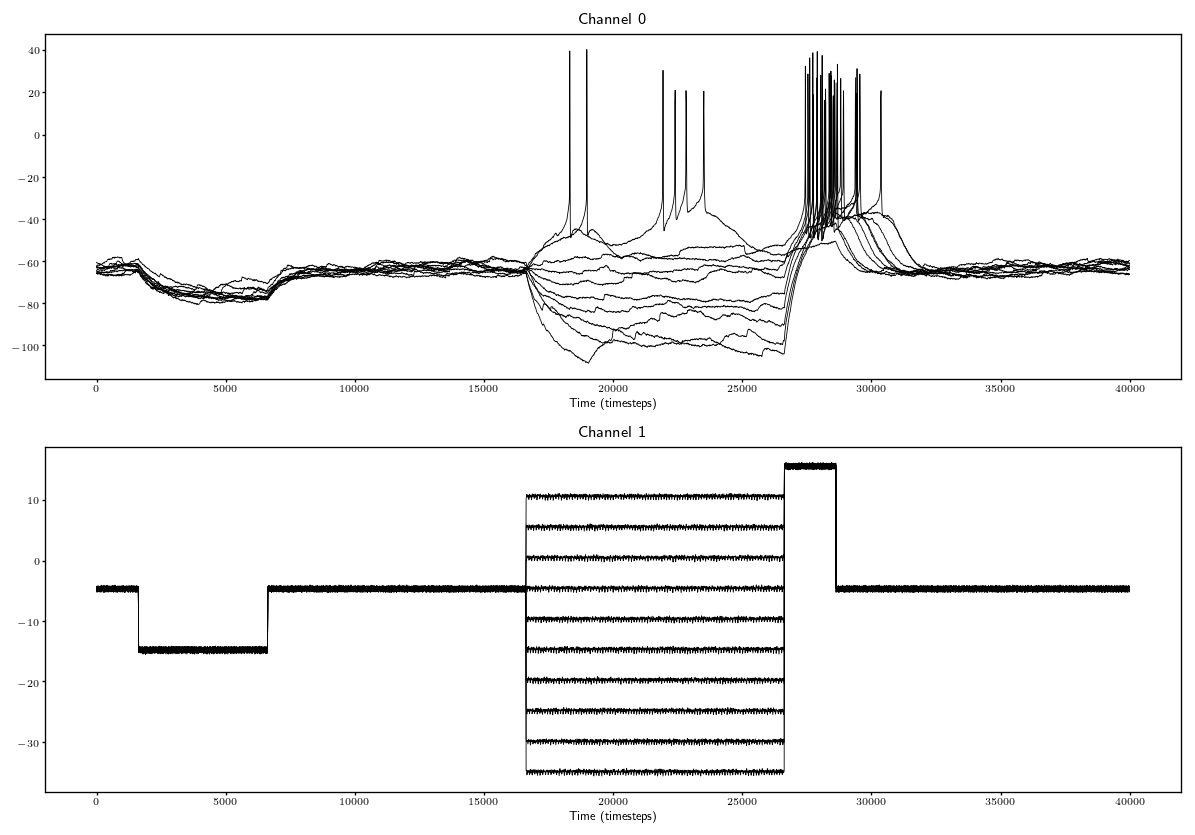

In [7]:
experiments[0][0].plot()

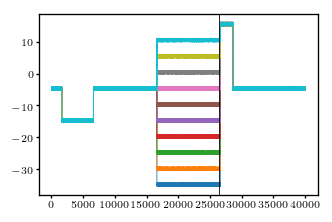

In [8]:
plt.plot(experiments[0][0][1, ...])
plt.axvline(latency_extraction_params['step_start_time'] / experiments[0][0].dt)

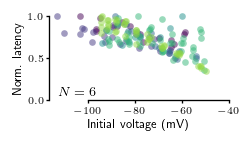

In [9]:

plt.figure(figsize=(2, 1))

plt.subplot(111)
for i, (latencies, voltages) in enumerate(zip(latency_data['latency'], latency_data['voltage'])):
    plt.plot(
        voltages, 
        latencies / np.nanmax(latencies), 
        'o',
        alpha=0.5,
        color=plt.cm.viridis(float(i)/len(latency_data['latency'])),
        markeredgecolor='none',
        markersize=4,
        clip_on=False
    )
plt.text(
    0.05, 
    0.05, 
    '$N = {}$'.format(len(latency_data['latency'])), 
    transform=plt.gca().transAxes
)
plt.ylim(0, 1)
plt.xticks(np.arange(-100, -20, 20))
plt.yticks([0, 0.5, 1])
plt.xlabel('Initial voltage (mV)')
plt.ylabel('Norm. latency')
hide_border('tr', trim=True)

plt.subplots_adjust(bottom=0.25, left=0.2, top=0.95, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'gaba_latency_steps.png'))
    plt.savefig(os.path.join(IMG_PATH, 'gaba_latency_steps.svg'))